In [1]:
import numpy as np
import pandas as pd

import gudhi as gd
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter

from pathlib import Path
from tqdm.notebook import tqdm

from src.inputreader import read_segmented_images, persistence_writer_ensure_filesize
from src.inputreader import read_persistence_files
from src.auxfunctions import compute_vectorizations_all
from src.auxfunctions import get_all_classifications

In [2]:
data_input = Path('data_segmented')
input_airyscan = data_input / 'Airyscan'
input_sted = data_input / 'STED'

data_pers = Path('data_processed')

pers_sted = data_pers / 'persistence_sted'
pers_airyscan = data_pers / 'persistence_airyscan'
pers_sted_other = data_pers / 'persistence_sted' / 'other_preprocessing'
pers_airyscan_other = data_pers / 'persistence_airyscan' / 'other_preprocessing'

vec_sted = data_pers / 'vectorizations_sted'
vec_airyscan = data_pers / 'vectorizations_airyscan'
vec_sted_other = data_pers / 'vectorizations_sted' / 'other_preprocessing'
vec_airyscan_other = data_pers / 'vectorizations_airyscan' / 'other_preprocessing'

classification_path_preproc = data_pers / 'classification' / 'preprocessing'

In [3]:

preprocessings = [
    'raw',
    'clip_gaussian2a_minmax',
    'clip_gaussian2c_minmax', 
    'clip_gaussian4a_minmax',
    'clip_gaussian4c_minmax',
    'clip_minmax_gaussian2a_minmax',
    'clip_minmax_gaussian2c_minmax', # this is the one used in the paper
    'clip_minmax_gaussian4a_minmax',
    'clip_minmax_gaussian4c_minmax',
    'clip',
    'clip_minmax'
]

preprocessing_in_paper = 'clip_minmax_gaussian2c_minmax'

In [4]:
def check_for_split_persistence_files(persistence_path,
    persistence_path_other,
    preproc, celltype,
    check_for_3d=False):
    """
    Check if the persistence files are split into multiple files.
    """ 
    # check if file exist in its split form
    files = list(persistence_path.glob(f'*persistence_{celltype.lower()}_{preproc}.npz'))
    if len(files) >= 1:
        if check_for_3d:
            if len([file for file in files if 'pers-3' if file.name]) > 0:
                return True
        else:
            return True
    
    files = list(persistence_path_other.glob(f'*persistence_{celltype.lower()}_{preproc}.npz'))
    if len(files) >= 1:
        if check_for_3d:
            if len([file for file in files if 'pers-3' if file.name]) > 0:
                return True
        else:
            return True
    
    return False

# Comparison preprocessing in classification accuracy

# compute persistence

## STED

In [5]:
# get the metadata for the original files as well as the segmented files
df_sted_metadata = pd.read_csv(data_input/ 'sted_df_metadata.csv', comment='#')

masks, bounding_boxes, labels_str, labels, npzfiles = \
    read_segmented_images(input_sted, microscope='sted', replace_nan_with=0)

df_labels = pd.DataFrame(labels_str, columns=['labels_str'])
df_labels.loc[:, 'labels'] = labels
df_labels.loc[:, 'id'] = np.arange(len(labels))
df_labels.loc[:, 'microscope'] = 'sted'
df_labels.loc[:, 'filename'] = [f.name for f in npzfiles]
df_labels.to_csv(Path(data_pers, 'labels_persistence_sted.csv'),
                 index=False)

# get the physical pixel sizes for each image
for filename in npzfiles:
    assert len(df_sted_metadata.loc[df_sted_metadata['segmented_filename'] == filename.name, :]) == 1
pixelsizes = [df_sted_metadata.loc[df_sted_metadata['segmented_filename'] == filename.name,
                                   ['pixel_size_z', 'pixel_size_x', 'pixel_size_y']]\
                                    .values[0] for filename in npzfiles]
pixelsizes = np.array(pixelsizes)

100%|██████████| 478/478 [00:02<00:00, 214.35it/s]


In [6]:
sigma = 1

for preproc in preprocessings:
    # check if they have already been computed
    if check_for_split_persistence_files(pers_sted,
            pers_sted_other, 
            preproc, 'sted',
            check_for_3d=True):
        continue

    print(f'Compute persistence for preprocessing: {preproc}')

    pers_all = {2: [[], []], 3: [[], [], []]}
    for i, mask_loop in tqdm(enumerate(masks), total=len(masks)):
        mask = mask_loop.astype(np.float64)
        if np.any(np.isnan(mask)):
            assert np.nanmin(mask) == 0
            mask[np.isnan(mask)] = 0
        mask_org = mask.copy()

        if preproc != 'raw':
            quant05 = np.nanquantile(mask[mask > np.min(mask)], 0.05)
            quant95 = np.nanquantile(mask[mask > np.min(mask)], 0.95)
            mask = np.clip(mask, quant05, quant95)
        
        if 'clip_minmax' in preproc:
            mask = MinMaxScaler().fit_transform(mask.reshape(-1, 1)).reshape(mask.shape)
        
        if 'gaussian' in preproc and ('a_minmax' in preproc or 'a_mask0' in preproc or preproc.endswith('a')):
            sigma_pixels = 1
        elif 'gaussian' in preproc and ('b_minmax' in preproc or 'b_mask0' in preproc or preproc.endswith('b')):
            # set the sigmas such that pixel_x and pixel_y are 1
            sigma_pixels = pixelsizes[i].copy()
            # x and y resolution should be the same
            assert sigma_pixels[1] == sigma_pixels[2]
            sigma_pixels /= sigma_pixels[1]
        elif 'gaussian' in preproc and ('c_minmax' in preproc or 'c_mask0' in preproc or preproc.endswith('c')):
            # set the sigmas such that pixel_z are 1
            sigma_pixels = pixelsizes[i].copy()
            # x and y resolution should be the same
            assert sigma_pixels[1] == sigma_pixels[2]
            sigma_pixels /= sigma_pixels[0]
        
        if 'gaussian' in preproc:
            gaussian_truncate = \
                int(preproc[preproc.find('gaussian') + len('gaussian'):].split('_')[0][:-1])
            mask = gaussian_filter(mask, sigma=sigma_pixels,
                    truncate=gaussian_truncate, mode='constant', cval=0.0)
    
        if preproc.endswith('minmax') or preproc.endswith('minmax_mask0'):
            mask = MinMaxScaler().fit_transform(mask.reshape(-1, 1)).reshape(mask.shape)
        if 'mask0' in preproc:
            mask[mask_org == 0] = 0
        clipped_images = mask.copy()

        # print(i, np.min(clipped_images), np.max(clipped_images), np.shape(clipped_images))
        
        for max_dim in [2, 3]:
            if max_dim == 2:
                cc = gd.CubicalComplex(top_dimensional_cells= -np.max(clipped_images.astype(np.float64), axis=0))
            else:
                cc = gd.CubicalComplex(top_dimensional_cells= -clipped_images.astype(np.float64))
            cc.compute_persistence()

            for dimi in range(max_dim):
                persistence = cc.persistence_intervals_in_dimension(dimi)
                pers_all[max_dim][dimi].append(persistence.copy())
            
        # print('Done with image:', i, 'of', len(masks), 'for preproc:', preproc)

    pers_save = {'labels': labels_str}
    for key in pers_all.keys():
        for dim in range(len(pers_all[key])):
            for i in range(len(pers_all[key][dim])):
                newkey = f'pers-{key}_dim-{dim}_i-{i:04d}'
                assert newkey not in pers_save
                pers_save[newkey] = pers_all[key][dim][i].copy()
                if np.shape(pers_all[key][dim][i])[0] < 10:
                    print(newkey, key, dim, i, np.shape(pers_all[key][dim][i])[0])

    # NOW save the persistence files
    if preproc == preprocessing_in_paper:
        filepath = pers_sted/f'persistence_sted_{preproc}.npz'
    else:
        filepath = pers_sted_other/f'persistence_sted_{preproc}.npz'
    np.savez_compressed(filepath, **pers_save)

    # check the filesize and delete it if it is too large
    # this is done to ensure the non-LFS filesize of github
    # if filepath.is_file() and filepath.stat().st_size / (1024*1024) > 95:
    #     persistence_writer_ensure_filesize(filepath,
    #         maxfilesize=95, lowerlimit=90,
    #         split_names='splitfiles',
    #         pers2d3d=['pers-2', 'pers-3'])
        # filepath.unlink()
    # del pers_save
    # del pers_all

Compute persistence for preprocessing: clip_gaussian4c_minmax


  0%|          | 0/478 [00:00<?, ?it/s]

## airyscan

In [33]:
df_airy_metadata = pd.read_csv(data_input / 'airyscan_df_metadata.csv')
masks, bounding_boxes, labels_str, labels, npzfiles = read_segmented_images(input_airyscan, microscope='airyscan')

df_labels = pd.DataFrame(labels_str, columns=['labels_str'])
df_labels.loc[:, 'labels'] = labels
df_labels.loc[:, 'id'] = np.arange(len(labels))
df_labels.loc[:, 'microscope'] = 'airyscan'
df_labels.loc[:, 'filename'] = [f.name for f in npzfiles]

df_labels.to_csv(Path(data_pers, 'labels_persistence_airyscan.csv'),
                 index=False)

pixelsizes = [df_airy_metadata.loc[df_airy_metadata['segmented_filename'] == filename.name,
              ['pixel_size_z', 'pixel_size_x', 'pixel_size_y']]\
              .values[0] for filename in npzfiles]
pixelsizes = np.array(pixelsizes)

assert np.all(pixelsizes[:, 1] == pixelsizes[:, 2])

100%|██████████| 91/91 [00:01<00:00, 62.21it/s]


In [ ]:
sigma = 1

for preproc in preprocessings:
    # check if the persistence files already exist
    if check_for_split_persistence_files(pers_airyscan,
            pers_airyscan_other, preproc, 'airyscan'):
        continue

    print(f'Compute persistence for preprocessing: {preproc}')

    pers_all = {2: [[], []], 3: [[], [], []]}
    for i, mask_loop in tqdm(enumerate(masks), total=len(masks)):
        mask = mask_loop.astype(np.float64)
        if np.any(np.isnan(mask)):
            assert np.nanmin(mask) == 0
            mask[np.isnan(mask)] = 0
        mask_org = mask.copy()

        if preproc != 'raw':
            quant05 = np.nanquantile(mask[mask > np.min(mask)], 0.05)
            quant95 = np.nanquantile(mask[mask > np.min(mask)], 0.95)
            mask = np.clip(mask, quant05, quant95)
        
        if 'clip_minmax' in preproc:
            mask = MinMaxScaler().fit_transform(mask.reshape(-1, 1)).reshape(mask.shape)
        
        if 'gaussian' in preproc and ('a_minmax' in preproc or 'a_mask0' in preproc or preproc.endswith('a')):
            sigma_pixels = 1
        elif 'gaussian' in preproc and ('b_minmax' in preproc or 'b_mask0' in preproc or preproc.endswith('b')):
            # set the sigmas such that pixel_x and pixel_y are 1
            sigma_pixels = pixelsizes[i].copy()
            # x and y resolution should be the same
            assert sigma_pixels[1] == sigma_pixels[2]
            sigma_pixels /= sigma_pixels[1]
        elif 'gaussian' in preproc and ('c_minmax' in preproc or 'c_mask0' in preproc or preproc.endswith('c')):
            # set the sigmas such that pixel_z are 1
            sigma_pixels = pixelsizes[i].copy()
            # x and y resolution should be the same
            assert sigma_pixels[1] == sigma_pixels[2]
            sigma_pixels /= sigma_pixels[0]
        
        if 'gaussian' in preproc:
            gaussian_truncate = \
                int(preproc[preproc.find('gaussian') + len('gaussian'):].split('_')[0][:-1])
            mask = gaussian_filter(mask, sigma=sigma_pixels,
                    truncate=gaussian_truncate, mode='constant', cval=0.0)
        
        if preproc.endswith('minmax') or preproc.endswith('minmax_mask0'):
            mask = MinMaxScaler().fit_transform(mask.reshape(-1, 1)).reshape(mask.shape)
        if 'mask0' in preproc:
            mask[mask_org == 0] = 0
        clipped_images = mask.copy()

        for max_dim in [2, 3]:
            if max_dim == 2:
                cc = gd.CubicalComplex(top_dimensional_cells= -np.max(clipped_images.astype(np.float64), axis=0))
            else:
                cc = gd.CubicalComplex(top_dimensional_cells= -clipped_images.astype(np.float64))
            cc.compute_persistence()

            for dimi in range(max_dim):
                persistence = cc.persistence_intervals_in_dimension(dimi)
                pers_all[max_dim][dimi].append(persistence.copy())

    pers_save = {'labels': labels_str}
    for key in pers_all.keys():
        for dim in range(len(pers_all[key])):
            for i in range(len(pers_all[key][dim])):
                newkey = f'pers-{key}_dim-{dim}_i-{i:04d}'
                assert newkey not in pers_save
                pers_save[newkey] = pers_all[key][dim][i].copy()
                if np.shape(pers_all[key][dim][i])[0] < 10:
                    print(newkey, key, dim, i, np.shape(pers_all[key][dim][i])[0])

    if preproc == preprocessing_in_paper:
        filepath = pers_airyscan / f'persistence_airyscan_{preproc}.npz'
    else:
        filepath = pers_airyscan_other / f'persistence_airyscan_{preproc}.npz'
    np.savez_compressed(filepath, **pers_save)
    print(filepath)

    # check the filesize and delete it if it is too large
    # this is done to ensure the non LFS filesize of github
    if filepath.is_file() and filepath.stat().st_size / (1024*1024) < 95:
        persistence_writer_ensure_filesize(filepath,
            maxfilesize=95, lowerlimit=90,
            split_names='splitfiles',
            pers2d3d=['pers-2', 'pers-3'])
        filepath.unlink()
    del pers_save
    del pers_all

In [7]:
for preproc in tqdm(preprocessings):
    # check if the persistence files already exist
    if (preproc == preprocessing_in_paper
        and Path(pers_airyscan/f'persistence_airyscan_{preproc}.npz').exists()):
        continue
    if Path(pers_airyscan_other/f'persistence_airyscan_{preproc}.npz').exists():
        continue

    if preproc == preprocessing_in_paper:
        filepath = pers_airyscan / f'persistence_airyscan_{preproc}.npz'
    else:
        filepath = pers_airyscan_other / f'persistence_airyscan_{preproc}.npz'

    print(filepath)

  0%|          | 0/11 [00:00<?, ?it/s]

# compute classification perfomance

In [ ]:
# # This computes the vectorizations for all persistence files for the different preprocessing steps

# for microscope in ['sted', 'airyscan']:
#     for preprocessing in preprocessings:
#         if preprocessing == preprocessing_in_paper:
#             if microscope.lower() == 'sted':
#                 pers_folder = pers_sted
#                 vect_folder = vec_sted
#             elif microscope.lower() == 'airyscan':
#                 pers_folder = pers_airyscan
#                 vect_folder = vec_airyscan
#             else:
#                 raise ValueError('Microscope not recognized!')
        
#         else:
#             if microscope.lower() == 'sted':
#                 pers_folder = pers_sted_other
#                 vect_folder = vec_sted_other
#             elif microscope.lower() == 'airyscan':
#                 pers_folder = pers_airyscan_other
#                 vect_folder = vec_airyscan_other
#             else:
#                 raise ValueError('Microscope not recognized!')

#         pers_all, keys = read_persistence_files(pers_folder, preprocessing, return_keys=True)
#         if pers_all is None:
#             print('No persistence files for this preprocessing steps found!')
#         df_labels = pd.read_csv(data_pers / f'labels_persistence_{microscope.lower()}.csv')
#         labels = df_labels['labels'].values

#         df_vectorizations = compute_vectorizations_all(labels, pers_all, resolution_pi=20, bandwidth=4, resolution_bc=250)
#         df_vectorizations.to_csv(vect_folder / f'vectorizations_all_{microscope.lower()}_{preprocessing}.csv',
#                                 index=False)

In [7]:
for celltype in ['airyscan', 'sted']:

    df_labels = pd.read_csv(data_pers / f'labels_persistence_{celltype}.csv')
    labels = df_labels['labels'].values

    for preproc in preprocessings:
        if preproc == preprocessing_in_paper:
            if celltype == 'sted':
                pers_folder = pers_sted
            else:
                pers_folder = pers_airyscan
        else:
            if celltype == 'sted':
                pers_folder = pers_sted_other
            else:
                pers_folder = pers_airyscan_other
        
        text = celltype + preproc
        files = Path('data_processed', 'classification', 'preprocessing').\
            rglob(f'preprocessing_classification*{text}.csv')
        if len(list(files)) == 1:
            continue

        get_all_classifications(preproc,
            pers_folder, 
            classification_path_preproc,
            labels,
            runs=10, train_percent='70', run_start=0,
            nameappend=f'preprocessing_',
            saveasfile=True)

Classification file: data_processed/classification/preprocessing/preprocessing_classification_airyscan_traintest_runs-10_perc-70_airyscan_raw.csv ,
  reading: persistence_airyscan_raw.npz
File already exists
Classification file: data_processed/classification/preprocessing/preprocessing_classification_airyscan_traintest_runs-10_perc-70_airyscan_clip_gaussian2a_minmax.csv ,
  reading: persistence_airyscan_clip_gaussian2a_minmax.npz
File already exists
Classification file: data_processed/classification/preprocessing/preprocessing_classification_airyscan_traintest_runs-10_perc-70_airyscan_clip_gaussian2c_minmax.csv ,
  reading: persistence_airyscan_clip_gaussian2c_minmax.npz
File already exists
Classification file: data_processed/classification/preprocessing/preprocessing_classification_airyscan_traintest_runs-10_perc-70_airyscan_clip_gaussian4a_minmax.csv ,
  reading: persistence_airyscan_clip_gaussian4a_minmax.npz
File already exists
Classification file: data_processed/classification/pre

ValueError: More than one persistence file found

In [8]:
preproc

'clip'

## visualization

In [51]:
files = sorted(classification_path_preproc.glob('*.csv'))

for microscope in ['sted', 'airyscan']:
    for preproc in preprocessings:
        if len([file for file in files if microscope in file.name and preproc in file.name]) != 1:
            print(f'{microscope}, {preproc} either nothing found or more than one file found')

sted, clip either nothing found or more than one file found
sted, clip_minmax either nothing found or more than one file found
airyscan, clip either nothing found or more than one file found
airyscan, clip_minmax either nothing found or more than one file found


In [55]:
df = []
for file in files:
    df_tmp = pd.read_csv(file)
    if 'sted' in file.name:
        df_tmp['microscope'] = 'sted'
    else:
        df_tmp['microscope'] = 'airyscan'
    df.append(df_tmp)

df = pd.concat(df, axis=0).reset_index(drop=True)
df = df.drop(columns=['birth_threshold', 'persistence_threshold'])

# WE have some preprocessing steps that are not yet computed
df_count = df.groupby(['prefix']).count()['dim'].reset_index()
preprocessings_computed = list(df_count.loc[df_count['dim'] == 240, 'prefix'].values)
df = df.loc[df['prefix'].isin(preprocessings_computed), :].reset_index(drop=True)

df

,prefix,dim,type,accuracy_balanced,accuracy_train,precision,recall,run,hash_train,hash_test,microscope
0,clip_gaussian2a_minmax,2,stat,0.696970,0.982143,0.734586,0.685714,0,4a45b76301a5bda2b2e9e9b16df34a90653a7bb3a45fb5...,d3d833d4970af6564a470a28f7c123b9e1820b90489eb3...,airyscan
1,clip_gaussian2a_minmax,3,stat,0.850379,1.000000,0.860952,0.828571,0,4a45b76301a5bda2b2e9e9b16df34a90653a7bb3a45fb5...,d3d833d4970af6564a470a28f7c123b9e1820b90489eb3...,airyscan
2,clip_gaussian2a_minmax,2,bc,0.808712,1.000000,0.832493,0.771429,0,4a45b76301a5bda2b2e9e9b16df34a90653a7bb3a45fb5...,d3d833d4970af6564a470a28f7c123b9e1820b90489eb3...,airyscan
3,clip_gaussian2a_minmax,3,bc,0.808712,1.000000,0.832493,0.771429,0,4a45b76301a5bda2b2e9e9b16df34a90653a7bb3a45fb5...,d3d833d4970af6564a470a28f7c123b9e1820b90489eb3...,airyscan
4,clip_gaussian2a_minmax,2,pi,0.825758,1.000000,0.840959,0.828571,0,4a45b76301a5bda2b2e9e9b16df34a90653a7bb3a45fb5...,d3d833d4970af6564a470a28f7c123b9e1820b90489eb3...,airyscan
...,...,...,...,...,...,...,...,...,...,...,...
2395,raw,3,ent,0.975410,0.976190,0.970269,0.967391,9,f166a08a0400d84cc6ae1e2f1fd3011fe4a4cf0d349351...,ea97c363da9dd8210377bcd37dae83d333cefc66060695...,sted
2396,raw,2,ecc,0.886039,0.993197,0.889601,0.880435,9,f166a08a0400d84cc6ae1e2f1fd3011fe4a4cf0d349351...,ea97c363da9dd8210377bcd37dae83d333cefc66060695...,sted
2397,raw,3,ecc,0.951216,0.959184,0.952181,0.951087,9,f166a08a0400d84cc6ae1e2f1fd3011fe4a4cf0d349351...,ea97c363da9dd8210377bcd37dae83d333cefc66060695...,sted
2398,raw,2,all,0.983739,1.000000,0.983823,0.983696,9,f166a08a0400d84cc6ae1e2f1fd3011fe4a4cf0d349351...,ea97c363da9dd8210377bcd37dae83d333cefc66060695...,sted


In [57]:
df = df.drop(columns=['run', 'hash_train', 'hash_test'])

In [58]:
df.loc[(df['microscope'] == 'airyscan') & (df['type'] == 'all'), :]

,prefix,dim,type,accuracy_balanced,accuracy_train,precision,recall,microscope
10,clip_gaussian2a_minmax,2,all,0.829545,1.000000,0.846053,0.800000,airyscan
11,clip_gaussian2a_minmax,3,all,0.767045,1.000000,0.808271,0.714286,airyscan
22,clip_gaussian2a_minmax,2,all,0.804924,1.000000,0.822449,0.800000,airyscan
23,clip_gaussian2a_minmax,3,all,0.825758,1.000000,0.840959,0.828571,airyscan
34,clip_gaussian2a_minmax,2,all,0.933712,1.000000,0.942857,0.942857,airyscan
...,...,...,...,...,...,...,...,...
1175,raw,3,all,0.850379,1.000000,0.860952,0.828571,airyscan
1186,raw,2,all,0.937500,1.000000,0.932653,0.914286,airyscan
1187,raw,3,all,0.933712,1.000000,0.942857,0.942857,airyscan
1198,raw,2,all,0.875000,1.000000,0.889076,0.828571,airyscan


PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.

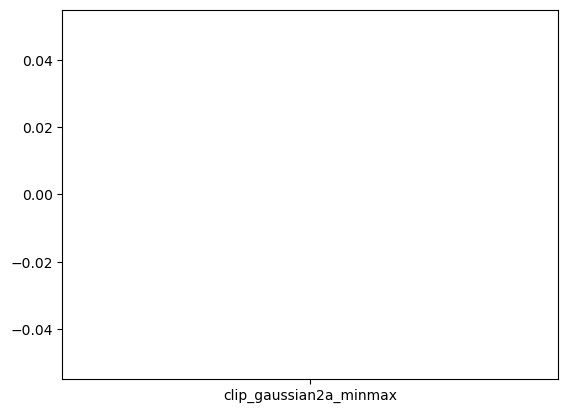

In [65]:
import seaborn as sns
sns.boxplot(data=df, x='prefix', y='accuracy_balanced')